<a href="https://colab.research.google.com/github/arielwendichansky/DI_Bootcamp/blob/master/Week5/Day2/Daily_challenge/Analyzing_The_IMDB_Movie_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import math
from sklearn.metrics import roc_curve, roc_auc_score
from scipy import stats, cluster
from scipy.optimize import minimize_scalar
from scipy.stats import skew, kurtosis, median_test,ttest_ind, norm

# Extracting data from Kaggle



In [ ]:
! pip install -k kaggle
from google.colab import files
files.upload()

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows

In [ ]:
!unzip 'imdb-dataset-of-top-1000-movies-and-tv-shows.zip'

In [9]:
df = pd.read_csv('imdb_top_1000.csv')

# Initial Data Exploration

In [10]:
df.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Poster_Link    1000 non-null   object 
 1   Series_Title   1000 non-null   object 
 2   Released_Year  1000 non-null   object 
 3   Certificate    899 non-null    object 
 4   Runtime        1000 non-null   object 
 5   Genre          1000 non-null   object 
 6   IMDB_Rating    1000 non-null   float64
 7   Overview       1000 non-null   object 
 8   Meta_score     843 non-null    float64
 9   Director       1000 non-null   object 
 10  Star1          1000 non-null   object 
 11  Star2          1000 non-null   object 
 12  Star3          1000 non-null   object 
 13  Star4          1000 non-null   object 
 14  No_of_Votes    1000 non-null   int64  
 15  Gross          831 non-null    object 
dtypes: float64(2), int64(1), object(13)
memory usage: 125.1+ KB


In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
IMDB_Rating,1000.0,7.94930,0.275491,7.6,7.70,7.9,8.10,9.3
Meta_score,843.0,77.97153,12.376099,28.0,70.00,79.0,87.00,100.0
No_of_Votes,1000.0,273692.91100,327372.703934,25088.0,55526.25,138548.5,374161.25,2343110.0


#Data cleaning

In [13]:
df = df.drop(columns=['Poster_Link','Overview'])

In [14]:
# Converting year column from string to date time
df['Released_Year'] = pd.to_datetime(df['Released_Year'], errors='coerce').dt.year

In [15]:
# Converting string values to numeric values so to fill null ones with mean
df['Gross'] = pd.to_numeric(df['Gross'].str.replace(',', ''), errors='coerce')

In [16]:
# Filling null values with the mean value for each column
df['Gross'] = df['Gross'].fillna(df['Gross'].mean())
df['Meta_score'] = df['Meta_score'].fillna(df['Meta_score'].mean())

# Data Analysis

In [18]:
cdata = df.copy()
# Plot the histogram
fig = px.histogram(cdata, x='Released_Year', title='Movie Distribution by Years', labels={'Released_Year': 'Year', 'count': 'Number Movies'})

# Show the plot
fig.show()

In [19]:
# Group by year with the mean IMDb rating
cdata_agg = cdata.groupby('Released_Year')['IMDB_Rating'].mean().reset_index()

# Plot trend line
fig = px.line(cdata_agg, x='Released_Year', y='IMDB_Rating', title='Average Movie Rating by Year')

# Show the plot
fig.show()


We can see the average rating trend over the year with a pick in 1936. It's important to consider the above plot to evaluate how many movies we have in the dataset for each year.

In [20]:
max_index = df['IMDB_Rating'].idxmax()
max_movie = df.loc[max_index, 'Series_Title']
max_movie_year = int(df.loc[max_index, 'Released_Year'])
print('With a rating of',df['IMDB_Rating'].max(), 'the movie with the highest IMDB rating is:', max_movie,'\nThe movie was released in:',max_movie_year )

min_index = df['IMDB_Rating'].idxmin()
min_movie = df.loc[min_index, 'Series_Title']
min_movie_year=int(df.loc[min_index, 'Released_Year'])
print('\nWith a rating of',df['IMDB_Rating'].min(), 'the movie with the lowest IMDB rating is:', min_movie,'\nThe movie was released in:',min_movie_year )


With a rating of 9.3 the movie with the highest IMDB rating is: The Shawshank Redemption 
The movie was released in: 1994

With a rating of 7.6 the movie with the lowest IMDB rating is: Dark Waters 
The movie was released in: 2019


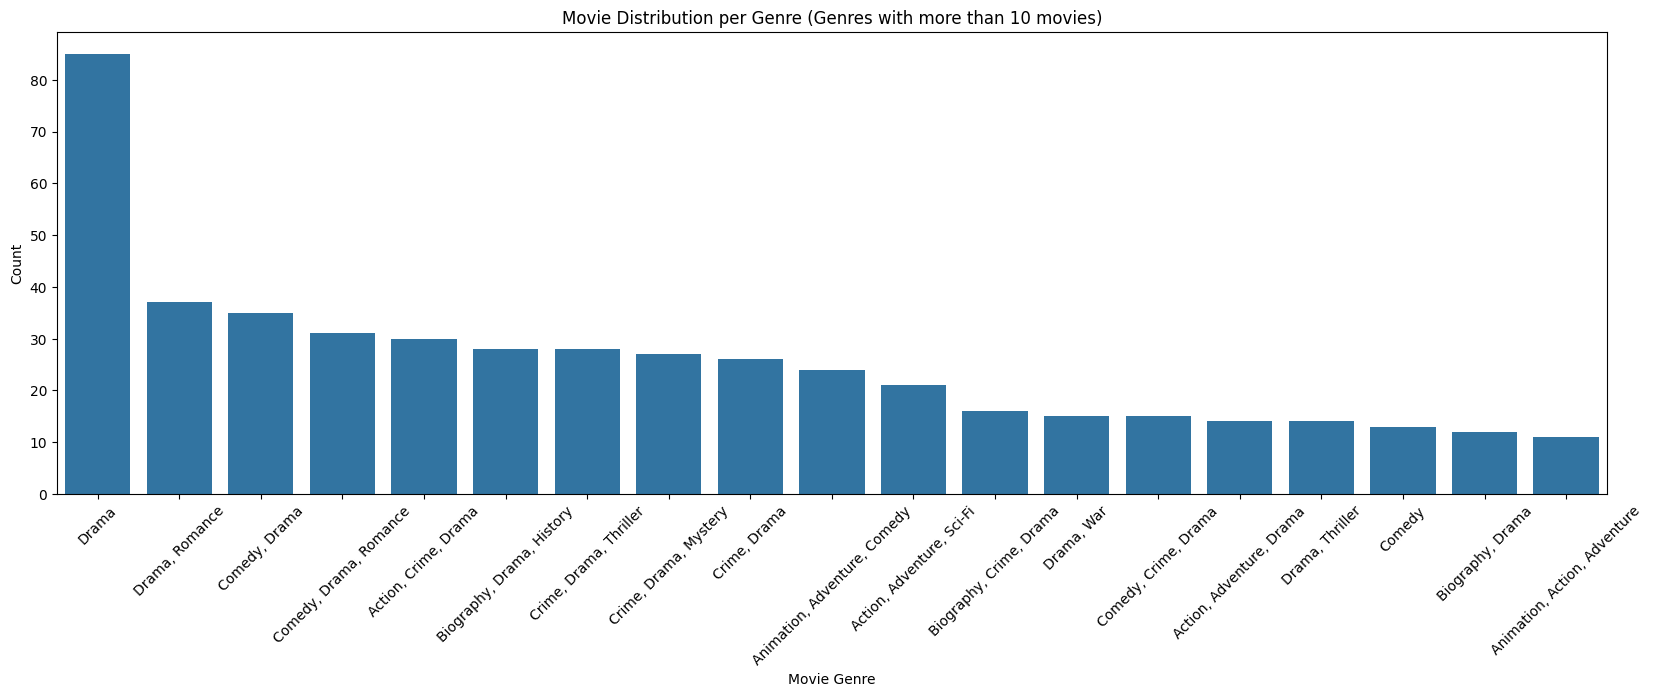

In [21]:
plt.figure(figsize=(20, 6))

# Filter genres with more than 10 movies
popular_genres = cdata['Genre'].value_counts()[cdata['Genre'].value_counts() > 10].index

# Filter the DataFrame
filtered_data = cdata[cdata['Genre'].isin(popular_genres)]

sns.countplot(data=filtered_data, x='Genre', order=filtered_data['Genre'].value_counts().index)
plt.xlabel('Movie Genre')
plt.ylabel('Count')
plt.title('Movie Distribution per Genre (Genres with more than 10 movies)')
plt.xticks(rotation=45)
plt.show()


In [22]:
director_ratings = cdata.groupby('Director')['IMDB_Rating'].mean().reset_index()
# Filtering only the Directors with an average rating over 8.5
top_directors = director_ratings[director_ratings['IMDB_Rating'] > 8.4]
print(top_directors)

# Filter movies directed by top directors
movies_top_director = cdata[cdata['Director'].isin(top_directors['Director'])]

               Director  IMDB_Rating
83    Christopher Nolan       8.4625
135  Fernando Meirelles       8.6000
141      Frank Darabont       8.9500
158        George Lucas       8.6000
191      Irvin Kershner       8.7000
284      Lana Wachowski       8.7000
316    Masaki Kobayashi       8.6000
342        Milos Forman       8.5000
366     Olivier Nakache       8.5000
427     Roberto Benigni       8.6000
428        Roger Allers       8.5000
472       Sudha Kongara       8.6000
492         Thomas Kail       8.6000


In [23]:
# Plot the relationship between director and average IMDb rating
fig = px.scatter(movies_top_director, x='Director', y='IMDB_Rating', title='IMDb Rating by Top Director', hover_data={'Series_Title': True})

fig.update_layout(xaxis={'tickangle': 90}) # Rotate x-axis labels for better visibility
fig.show()

In [ ]:
import matplotlib.pyplot as plt

# Plot trend line
plt.plot(cdata['Released_Year'], cdata['avg_rate'])

# Set the title and labels
plt.title('Movies average rating over years')
plt.xlabel('Released Year')
plt.ylabel('Average Rating')

# Show the plot
plt.show()


In [32]:
cdata['IMDB_Rating'].mean()

7.949299999999999

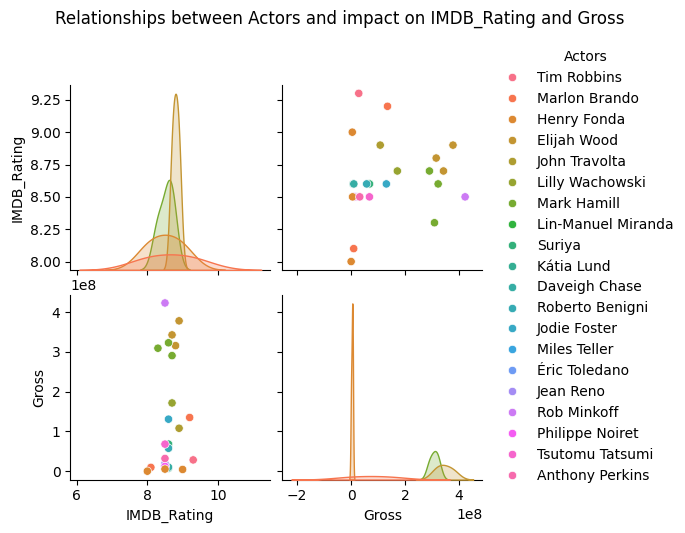

In [46]:
# Rating stars by average
stars_rating = cdata.groupby('Star1')['IMDB_Rating'].mean().reset_index()
# filtering stars with lower rating than 8.4
top_stars_list = stars_rating[stars_rating['IMDB_Rating'] > 8.4]
# Using the info from df with only stars which average rating is over 8.4
top_stars_df = cdata[cdata['Star1'].isin(top_stars_list['Star1'])]

columns = ['IMDB_Rating','Gross','Star1']

subset = top_stars_df[columns]
subset = subset.rename(columns={'Star1': 'Actors'})

sns.pairplot(data=subset, hue= 'Actors')
plt.suptitle('Relationships between Actors and impact on IMDB_Rating and Gross', y=1.05)
plt.subplots_adjust(top=0.9)
plt.show()


In [51]:
cdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   1000 non-null   object 
 1   Released_Year  999 non-null    float64
 2   Certificate    899 non-null    object 
 3   Runtime        1000 non-null   object 
 4   Genre          1000 non-null   object 
 5   IMDB_Rating    1000 non-null   float64
 6   Meta_score     1000 non-null   float64
 7   Director       1000 non-null   object 
 8   Star1          1000 non-null   object 
 9   Star2          1000 non-null   object 
 10  Star3          1000 non-null   object 
 11  Star4          1000 non-null   object 
 12  No_of_Votes    1000 non-null   int64  
 13  Gross          1000 non-null   float64
dtypes: float64(4), int64(1), object(9)
memory usage: 109.5+ KB


<Axes: >

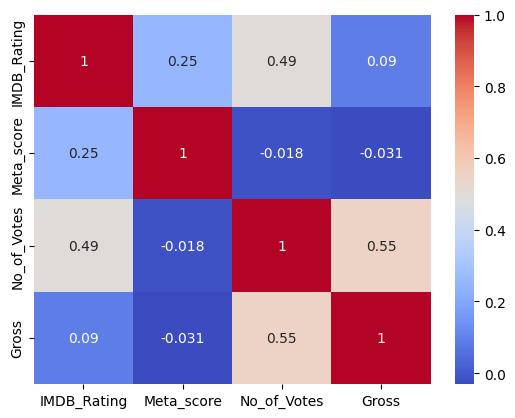

In [57]:
numeric_columns= ['IMDB_Rating','Meta_score','No_of_Votes','Gross']
corr_data = cdata[numeric_columns]

corr_matrix = cdata[numeric_columns].corr()

sns.heatmap(corr_matrix,annot=True, cmap='coolwarm')